In [1]:
# Import `numpy` under the alias `np`
import numpy as np 

# Import `pandas` under the alias `pd`
import pandas as pd 
import pmdarima as pm

import itertools #to iterate through the loops

import statsmodels.api as sm

import matplotlib.pyplot as plt 
import matplotlib as mpl
%matplotlib inline 

import plotly.express as px
import plotly.offline as py

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from pandas import Series

from datetime import datetime
from matplotlib import pyplot


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

#FBProphet related imports
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

#Importing the Auto-Arima function 
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error

 # to split the data into train and test parts
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score 


def p_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Reading the data from a file

In [2]:
df = pd.read_excel('C:/Users/ADMIN/Desktop/capstone project/Sales Forecast_Sales_Forecast_Data.xlsx')

In [3]:
df.head() # returns top n (5 by default) rows of a data frame

FIN_YEAR MONTH    STATE            FG DISTRICT  COMPANY    VALUE
0  2014-2015   Nov  Haryana  Insecticides   Rohtak  monous    675.00
1  2014-2015   Nov  Haryana  Insecticides   Rewari  monous     73.71
2  2014-2015   Nov  Haryana  Insecticides  Gurgaon  monous    405.00
3  2014-2015   Nov  Haryana  Insecticides    Mewat  monous   1188.00
4  2014-2015   Nov  Haryana  Insecticides   Palwal  monous   5188.59

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230152 entries, 0 to 230151
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   FIN_YEAR  230152 non-null  object 
 1   MONTH     230152 non-null  object 
 2   STATE     230152 non-null  object 
 3   FG        230152 non-null  object 
 4   DISTRICT  230152 non-null  object 
 5   COMPANY   230152 non-null  object 
 6   VALUE     230152 non-null  float64
dtypes: float64(1), object(6)
memory usage: 12.3+ MB


# Data Preparation for modelling : using ABC Manufacturing data only

In [5]:
#Constants used within this file
train_start_date = '2014-01-01'
train_end_date = '2017-06-01'
test_start_date = '2017-07-01'
test_end_date = '2017-12-01'
consider_rolling_window = False
consider_mean_values = False
predict_periods=6
missing_record_index = 37

In [6]:
if consider_rolling_window == True:
    rolling_period = 3
else:
    #do not change this value
    rolling_period = 1     

In [7]:
#Creating a dataframe of ABC manufacturing
ABC_df = df.loc[df['COMPANY'] == 'ABC Manufacturing']

In [8]:
#converting year range to year  . for example  "2014-2015"  will be converted to 2014 
ABC_df['FIN_YEAR'] = ABC_df.FIN_YEAR.str.slice(0,4)

#converting month to datetime for checking stationarity  
ABC_df['MONTH'] = pd.to_datetime(ABC_df['FIN_YEAR'].astype(str)+ "-"+ ABC_df['MONTH'].astype(str) + "-1")

In [9]:
ABC_df.isnull().sum() #Checking the null values in the ABC manufacturing company

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [10]:
ABC_df.isna().sum() 

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [11]:
#Considering only Punjab data for ABC manufacturing company only
ABC_df = ABC_df.loc[ (ABC_df['STATE'] == 'Punjab')]
ABC_df

FIN_YEAR      MONTH   STATE            FG     DISTRICT  \
2014       2014 2014-03-01  Punjab  Insecticides    Gurdaspur   
2015       2014 2014-03-01  Punjab  Insecticides   Kapurthala   
2016       2014 2014-03-01  Punjab  Insecticides    Jalandhar   
2017       2014 2014-03-01  Punjab  Insecticides   Hoshiarpur   
2018       2014 2014-03-01  Punjab  Insecticides   Nawanshahr   
...         ...        ...     ...           ...          ...   
230086     2016 2016-02-01  Punjab  Bactericides   Tarn Taran   
230087     2016 2016-02-01  Punjab  Bactericides     Rupnagar   
230088     2016 2016-02-01  Punjab  Bactericides  S.A.S Nagar   
230089     2016 2016-02-01  Punjab  Bactericides      Sangrur   
230090     2016 2016-02-01  Punjab  Bactericides      Barnala   

                  COMPANY     VALUE  
2014    ABC Manufacturing     0.000  
2015    ABC Manufacturing  1443.690  
2016    ABC Manufacturing  3889.755  
2017    ABC Manufacturing  1339.200  
2018    ABC Manufacturing   526.500  
...                   ...       ...  
230086  ABC Manufacturing     0.000  
230087  ABC Manufacturing     0.000  
230088  ABC Manufacturing     0.000  
230089  ABC Manufacturing     0.000  
230090  ABC Manufacturing     0.000  

[3668 rows x 7 columns]

In [12]:
ABC_df.describe()

VALUE
count   3668.000000
mean    2201.784046
std     4745.650177
min        0.000000
25%        0.000000
50%       41.782500
75%     1991.587500
max    56994.840000

In [13]:
ABC_df_Pesticides = ABC_df.copy(deep=True)
ABC_df_Pesticides.drop(['FIN_YEAR', 'STATE', 'FG', 'DISTRICT', 'COMPANY'],axis=1,inplace = True)

In [14]:
# Upon inspection it is found that for a period of Feb and March in 2017, there was no data. 
# We need to treat this data else seasonal_decompose() will throw error

In [15]:
# SUM 

if consider_mean_values == False:
    ABC_df_Pesticides = ABC_df_Pesticides.groupby('MONTH')['VALUE'].sum().reset_index()
    
    df1 = ABC_df_Pesticides[: missing_record_index]
    df2 = ABC_df_Pesticides[missing_record_index:]

    new_row = {'MONTH': datetime.strptime('2017-02-01', '%Y-%m-%d').date(), 'VALUE':125027.325}
    df1.loc[missing_record_index] = new_row

    new_row = {'MONTH': datetime.strptime('2017-03-01', '%Y-%m-%d').date(), 'VALUE':163238.04}
    df1.loc[missing_record_index + 1] = new_row
                        
    ABC_df_Pesticides = pd.concat([df1, df2])                                 

In [16]:
# MEAN 

if consider_mean_values == True:
    ABC_df_Pesticides = ABC_df_Pesticides.groupby('MONTH')['VALUE'].mean().reset_index()
    
    df1 = ABC_df_Pesticides[: missing_record_index]
    df2 = ABC_df_Pesticides[missing_record_index:]

    new_row = {'MONTH': datetime.strptime('2017-02-01', '%Y-%m-%d').date(), 'VALUE':4896}
    df1.loc[missing_record_index] = new_row

    new_row = {'MONTH': datetime.strptime('2017-03-01', '%Y-%m-%d').date(), 'VALUE':2073}
    df1.loc[missing_record_index + 1] = new_row
                        
    ABC_df_Pesticides = pd.concat([df1, df2])
    

In [17]:
ABC_df_Pesticides

MONTH       VALUE
0   2014-01-01 00:00:00  109526.175
1   2014-02-01 00:00:00  118257.165
2   2014-03-01 00:00:00   45239.580
3   2014-04-01 00:00:00  181633.185
4   2014-05-01 00:00:00  184528.935
5   2014-06-01 00:00:00  151493.085
6   2014-07-01 00:00:00   99722.475
7   2014-08-01 00:00:00  149691.915
8   2014-09-01 00:00:00  115486.965
9   2014-10-01 00:00:00  305785.800
10  2014-11-01 00:00:00  183920.490
11  2014-12-01 00:00:00  198224.280
12  2015-01-01 00:00:00  253721.835
13  2015-02-01 00:00:00  104799.285
14  2015-03-01 00:00:00  228154.725
15  2015-04-01 00:00:00  291320.955
16  2015-05-01 00:00:00  399479.040
17  2015-06-01 00:00:00  182901.105
18  2015-07-01 00:00:00  162270.135
19  2015-08-01 00:00:00  188838.945
20  2015-09-01 00:00:00  193174.470
21  2015-10-01 00:00:00  426452.310
22  2015-11-01 00:00:00  150497.730
23  2015-12-01 00:00:00  183275.190
24  2016-01-01 00:00:00   61821.630
25  2016-02-01 00:00:00  152025.525
26  2016-03-01 00:00:00  216319.815
27  2016-04-01 00:00:00   44783.685
28  2016-05-01 00:00:00  107567.190
29  2016-06-01 00:00:00  166298.940
30  2016-07-01 00:00:00  135769.500
31  2016-08-01 00:00:00  269317.980
32  2016-09-01 00:00:00  157380.570
33  2016-10-01 00:00:00  208027.170
34  2016-11-01 00:00:00  220494.015
35  2016-12-01 00:00:00  202958.730
36  2017-01-01 00:00:00   93745.890
37           2017-02-01  125027.325
38           2017-03-01  163238.040
37  2017-04-01 00:00:00   54139.320
38  2017-05-01 00:00:00  127212.660
39  2017-06-01 00:00:00  159290.145
40  2017-07-01 00:00:00   98945.145
41  2017-08-01 00:00:00  198493.335
42  2017-09-01 00:00:00  162217.890
43  2017-10-01 00:00:00  248477.085
44  2017-11-01 00:00:00  234001.035
45  2017-12-01 00:00:00  148460.850

<AxesSubplot:xlabel='MONTH', ylabel='VALUE'>

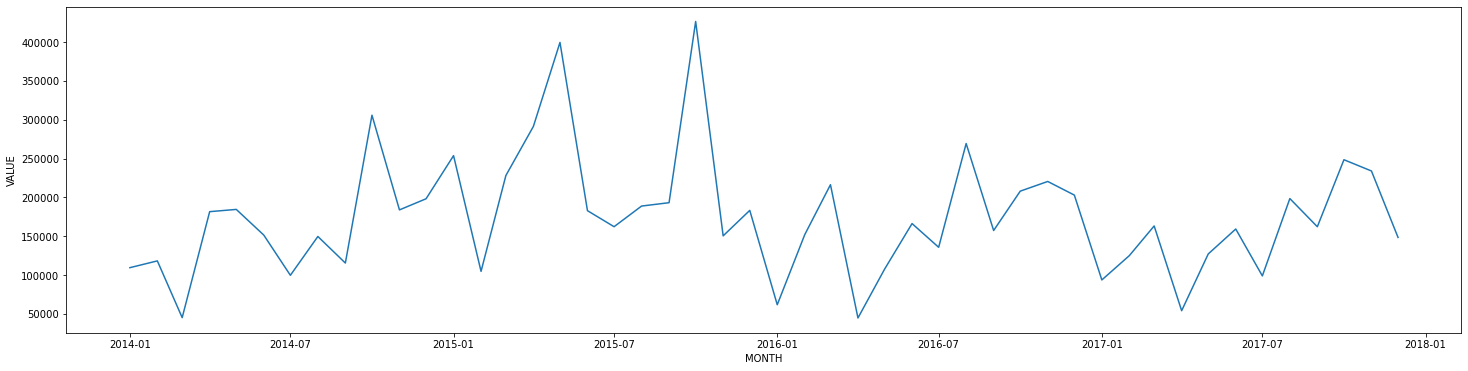

In [18]:
#Plot the data 
plt.figure(figsize=(25,6))
sns.lineplot(x="MONTH", y="VALUE", data=ABC_df_Pesticides,  ci= None)

In [19]:
if consider_rolling_window == True:
    xyzseries = ABC_df_Pesticides['VALUE'].rolling(window = rolling_period)
    XYZmean = xyzseries.mean()
    plt.figure(figsize=(25,6))
    sns.lineplot( data=XYZmean,  ci= None)
    

[Text(1, 0, 'VALUE')]

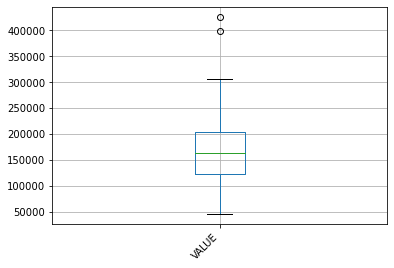

In [20]:
boxplot = ABC_df_Pesticides.boxplot(column=['VALUE'])
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, horizontalalignment='right')

In [21]:
ABC_df_Pesticides.describe()

VALUE
count      48.000000
mean   174258.525938
std     78396.766992
min     44783.685000
25%    123334.785000
50%    162754.087500
75%    204225.840000
max    426452.310000

In [22]:
print(ABC_df_Pesticides["VALUE"].quantile(0.95))

300723.1042499999


In [23]:
#ABC_df_Pesticides["VALUE"]=np.where(ABC_df_Pesticides["VALUE"]>66082.66875,66082.66875,ABC_df_Pesticides["VALUE"])

In [24]:
if consider_rolling_window == True:
    ABC_df_Pesticides['VALUE'] = XYZmean
    ABC_df_Pesticides = ABC_df_Pesticides[rolling_period - 1:]


# Check for Stationarity and Seasonality

In [25]:
# for a time series to be Sationary
# 1. Mean has to be constant 
# 2. variance has to be constant 
# 3. No seasonality

# If a timeseries has seasonality, then it is not stationary. i.e ARMA models cannot be run.

In [26]:
# Augmented Dickey FULLER test to check Stationarity

def ADF_test(timeseries):
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [27]:
ADF_test(ABC_df_Pesticides['VALUE'])

Test statistic = -5.732
P-value = 0.000
Critical values :
	1%: -3.5778480370438146 - The data is  stationary with 99% confidence
	5%: -2.925338105429433 - The data is  stationary with 95% confidence
	10%: -2.6007735310095064 - The data is  stationary with 90% confidence


In [28]:
# from the above result, as p-value < 0.05... we can conclude that the timeseries data is Stationary

In [29]:
# Additional check using KPSS method   [ Kwiatkowski–Phillips–Schmidt–Shin (KPSS)]
# Ref: https://www.statisticshowto.com/kpss-test/

stats, p, lags, critical_values = kpss(ABC_df_Pesticides['VALUE'],'c')
stats, p, lags, critical_values

print(f'Test Statistics: {stats}')
print(f'p value: {p}')
print(f'critical_values: {critical_values}')



Test Statistics: 0.1137888222991682
p value: 0.1
critical_values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [30]:
# as 0.1  is greater than 0.05, we can conclude that the timeseries data is Stationary

In [31]:
ABC_df_Pesticides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 0 to 45
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MONTH   48 non-null     object 
 1   VALUE   48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [32]:
# Reset index after converting 'Month' to Datetime
ABC_df_Pesticides['MONTH'] = pd.to_datetime(ABC_df_Pesticides['MONTH'])
ABC_df_Pesticides.set_index('MONTH', inplace=True)

In [33]:
ABC_df_Pesticides

VALUE
MONTH                 
2014-01-01  109526.175
2014-02-01  118257.165
2014-03-01   45239.580
2014-04-01  181633.185
2014-05-01  184528.935
2014-06-01  151493.085
2014-07-01   99722.475
2014-08-01  149691.915
2014-09-01  115486.965
2014-10-01  305785.800
2014-11-01  183920.490
2014-12-01  198224.280
2015-01-01  253721.835
2015-02-01  104799.285
2015-03-01  228154.725
2015-04-01  291320.955
2015-05-01  399479.040
2015-06-01  182901.105
2015-07-01  162270.135
2015-08-01  188838.945
2015-09-01  193174.470
2015-10-01  426452.310
2015-11-01  150497.730
2015-12-01  183275.190
2016-01-01   61821.630
2016-02-01  152025.525
2016-03-01  216319.815
2016-04-01   44783.685
2016-05-01  107567.190
2016-06-01  166298.940
2016-07-01  135769.500
2016-08-01  269317.980
2016-09-01  157380.570
2016-10-01  208027.170
2016-11-01  220494.015
2016-12-01  202958.730
2017-01-01   93745.890
2017-02-01  125027.325
2017-03-01  163238.040
2017-04-01   54139.320
2017-05-01  127212.660
2017-06-01  159290.145
2017-07-01   98945.145
2017-08-01  198493.335
2017-09-01  162217.890
2017-10-01  248477.085
2017-11-01  234001.035
2017-12-01  148460.850

<AxesSubplot:xlabel='MONTH'>

<Figure size 2160x2520 with 0 Axes>

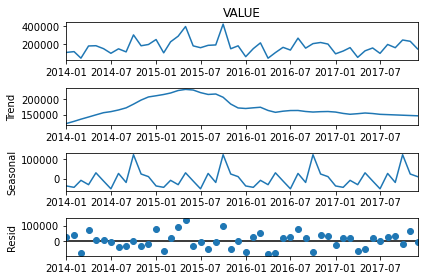

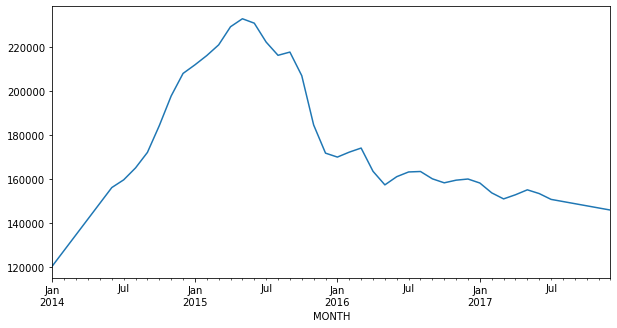

In [34]:
res = sm.tsa.seasonal_decompose(ABC_df_Pesticides['VALUE'],model = 'additive',extrapolate_trend='freq')

plt.figure(figsize=(30,35))
resplot = res.plot(observed=True)

plt.figure(figsize=(10, 5))
res.trend.plot()

# FBProphet Model

In [35]:
ABC_df_Pesticides_FBP =  ABC_df_Pesticides.copy(deep=True)

In [36]:
ABC_df_Pesticides_FBP = ABC_df_Pesticides_FBP.reset_index()[['MONTH','VALUE']].rename({'MONTH':'ds','VALUE':'y'}, axis='columns')

In [37]:
train = ABC_df_Pesticides_FBP[ABC_df_Pesticides_FBP['ds'] <= pd.to_datetime(train_end_date)]
train

ds           y
0  2014-01-01  109526.175
1  2014-02-01  118257.165
2  2014-03-01   45239.580
3  2014-04-01  181633.185
4  2014-05-01  184528.935
5  2014-06-01  151493.085
6  2014-07-01   99722.475
7  2014-08-01  149691.915
8  2014-09-01  115486.965
9  2014-10-01  305785.800
10 2014-11-01  183920.490
11 2014-12-01  198224.280
12 2015-01-01  253721.835
13 2015-02-01  104799.285
14 2015-03-01  228154.725
15 2015-04-01  291320.955
16 2015-05-01  399479.040
17 2015-06-01  182901.105
18 2015-07-01  162270.135
19 2015-08-01  188838.945
20 2015-09-01  193174.470
21 2015-10-01  426452.310
22 2015-11-01  150497.730
23 2015-12-01  183275.190
24 2016-01-01   61821.630
25 2016-02-01  152025.525
26 2016-03-01  216319.815
27 2016-04-01   44783.685
28 2016-05-01  107567.190
29 2016-06-01  166298.940
30 2016-07-01  135769.500
31 2016-08-01  269317.980
32 2016-09-01  157380.570
33 2016-10-01  208027.170
34 2016-11-01  220494.015
35 2016-12-01  202958.730
36 2017-01-01   93745.890
37 2017-02-01  125027.325
38 2017-03-01  163238.040
39 2017-04-01   54139.320
40 2017-05-01  127212.660
41 2017-06-01  159290.145

In [38]:
test = ABC_df_Pesticides_FBP[ABC_df_Pesticides_FBP['ds'] > pd.to_datetime(train_end_date)]
test

ds           y
42 2017-07-01   98945.145
43 2017-08-01  198493.335
44 2017-09-01  162217.890
45 2017-10-01  248477.085
46 2017-11-01  234001.035
47 2017-12-01  148460.850

In [39]:
test.rename({'ds' : 'MONTH','y' : 'VALUE'},axis=1,inplace=True)
test.set_index('MONTH', inplace=True)

In [40]:
test

VALUE
MONTH                 
2017-07-01   98945.145
2017-08-01  198493.335
2017-09-01  162217.890
2017-10-01  248477.085
2017-11-01  234001.035
2017-12-01  148460.850

In [41]:
#run the model with confidence interval of 95%
m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [42]:
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
m.params

{'k': array([[-0.05002655]]),
 'm': array([[0.42144887]]),
 'delta': array([[ 5.85655200e-12, -1.02155511e-10, -8.41447539e-12,
         -5.23823696e-11, -5.82402004e-11, -7.44419842e-11,
         -9.71399655e-11, -1.12534545e-04, -2.04719025e-04,
         -3.19357821e-04, -1.63134346e-04, -3.07830611e-04,
         -3.44068012e-04, -1.28680823e-04, -2.09543117e-04,
         -1.29246824e-04, -7.02894876e-10, -3.67270799e-09,
          1.49184845e-11, -3.46507578e-10, -1.96572535e-10,
          5.70905392e-12, -9.01253559e-11,  1.99700575e-11,
         -1.03454071e-10]]),
 'sigma_obs': array([[0.11267846]]),
 'beta': array([[-0.1090478 , -0.03129161,  1.48571458, -0.67341686, -1.11130585,
          0.10380383, -1.20278768,  0.26587525,  0.65670284, -0.23520365,
          0.36842413,  0.01634884,  0.73756318,  0.4457254 , -1.00040454,
         -0.43890295, -1.08179499, -0.42935476,  1.28391396,  0.88316163]]),
 'trend': array([[0.42144887, 0.42020523, 0.41908194, 0.41783829, 0.41663477,
 

In [44]:
future = m.make_future_dataframe(periods=predict_periods,freq='MS')

In [45]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds           yhat     yhat_lower     yhat_upper
0  2014-01-01  139959.087961   47904.530669  233915.814026
1  2014-02-01  141459.540548   53273.330343  230244.512703
2  2014-03-01  151105.831664   56060.534958  248647.243065
3  2014-04-01  175879.776274   80057.288281  277653.518426
4  2014-05-01  241860.571149  139462.997098  334173.752331
5  2014-06-01  160290.217003   60095.823096  257580.045219
6  2014-07-01  131854.654070   46968.442903  230733.753721
7  2014-08-01  192921.403329   99765.672733  287286.137728
8  2014-09-01  161236.444363   69807.282404  258414.233754
9  2014-10-01  343766.075084  247595.150968  432522.041971
10 2014-11-01  186221.901847   95421.767473  281744.996379
11 2014-12-01  199998.801170  102024.903523  290906.385527
12 2015-01-01  132669.213838   40102.807546  228855.741214
13 2015-02-01  122002.780209   36461.071146  218900.647160
14 2015-03-01  104096.668584   13768.612155  195534.546102
15 2015-04-01  219075.043144  127291.021916  319785.804666
16 2015-05-01  288611.591166  203989.212956  380226.648763
17 2015-06-01  122648.804268   27278.026575  209319.882195
18 2015-07-01  104012.982691    8954.713342  191595.950757
19 2015-08-01  141458.079246   52740.758293  232856.220540
20 2015-09-01  159591.695029   67693.653252  261218.583066
21 2015-10-01  409216.550874  315246.846748  503485.275053
22 2015-11-01  161376.451364   67332.136323  250572.973683
23 2015-12-01  189091.875232   98452.073688  278441.356915
24 2016-01-01  124869.974263   32174.743211  213432.882601
25 2016-02-01  102003.604983   10664.570922  195461.984832
26 2016-03-01  223599.101780  132047.842480  317013.972580
27 2016-04-01   68299.684075  -26482.251026  169509.962595
28 2016-05-01  119403.958378   28346.683425  215398.240169
29 2016-06-01  205667.959821  109845.281300  297126.579691
30 2016-07-01  161093.916239   70593.459285  250531.913712
31 2016-08-01  272714.964894  169573.529826  377112.220444
32 2016-09-01  144507.388435   55294.287415  235724.309846
33 2016-10-01  186727.346182   94851.135246  276630.502807
34 2016-11-01  206970.351695  120363.242179  299708.683759
35 2016-12-01  195258.498749  104094.605491  283235.783054
36 2017-01-01  121486.615027   22615.972945  213336.384471
37 2017-02-01  135091.514184   37073.660272  225841.863660
38 2017-03-01  173903.056837   72453.030042  271865.380330
39 2017-04-01  108535.127478   18449.407362  202642.879958
40 2017-05-01  168352.109814   71363.578962  270917.238492
41 2017-06-01  170871.601209   79851.135871  264815.252214
42 2017-07-01  133779.967320   39594.162231  228499.146214
43 2017-08-01  219556.669380  124119.046871  317754.465423
44 2017-09-01  139048.226041   46403.004589  235126.196929
45 2017-10-01  252398.251253  155332.641808  350713.088997
46 2017-11-01  184222.142561   87410.261887  274876.440468
47 2017-12-01  184842.127531   86502.587981  274115.807851

<AxesSubplot:xlabel='ds'>

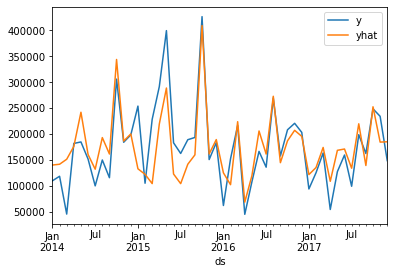

In [46]:
pd.concat([ABC_df_Pesticides_FBP.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

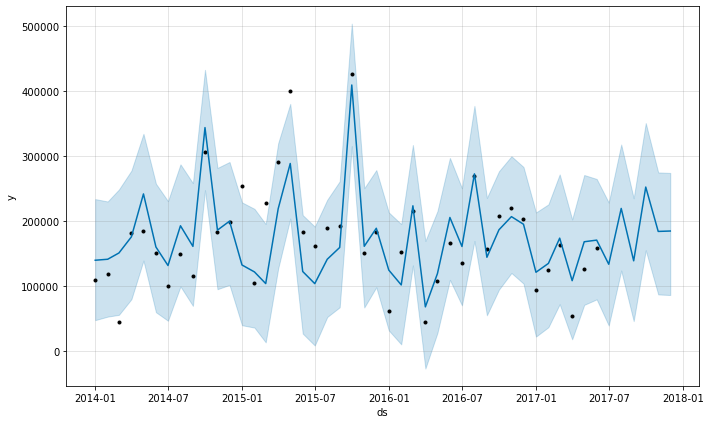

In [47]:
fig1 = m.plot(forecast)

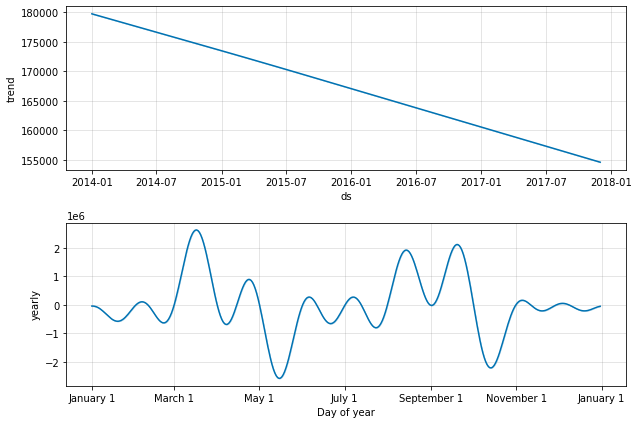

In [48]:
fig2 = m.plot_components(forecast)

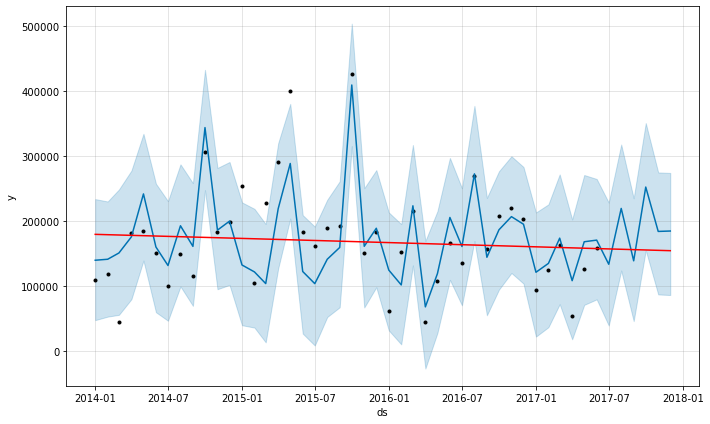

In [49]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [50]:
fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [51]:
#check for cross_validation
cv_results = cross_validation( model = m, initial = '731 days', horizon = '120 days')
cv_results

INFO:fbprophet:Making 7 forecasts with cutoffs between 2016-02-07 00:00:00 and 2017-02-01 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


ds           yhat     yhat_lower     yhat_upper           y  \
0  2016-03-01    2866.104930  -69401.659891   71126.769007  216319.815   
1  2016-04-01  350706.145155  279075.811143  421267.665422   44783.685   
2  2016-05-01  173361.870256  104659.403640  247624.309589  107567.190   
3  2016-06-01  486037.552587  414409.877814  553981.731612  166298.940   
4  2016-05-01  209236.150300  137449.448874  289358.496277  107567.190   
5  2016-06-01  516028.506678  442492.335539  592196.201476  166298.940   
6  2016-07-01  351778.655430  279186.525737  424325.410608  135769.500   
7  2016-08-01  359532.543277  283156.844904  440421.972750  269317.980   
8  2016-07-01  498384.108309  409178.663049  581661.771576  135769.500   
9  2016-08-01  414350.058169  330527.151551  500050.344361  269317.980   
10 2016-09-01  141018.297440   50850.110544  231198.751594  157380.570   
11 2016-10-01  110857.039977   24586.598515  202678.571329  208027.170   
12 2016-09-01  265306.929294  175720.355716  362583.627203  157380.570   
13 2016-10-01  154241.360839   55608.779820  254287.343266  208027.170   
14 2016-11-01  190387.356334   89095.571646  286098.991562  220494.015   
15 2016-12-01  161980.729390   63682.469580  255116.913097  202958.730   
16 2016-11-01  204219.912932  107153.693313  295686.004094  220494.015   
17 2016-12-01  156360.019325   58649.807495  258511.253106  202958.730   
18 2017-01-01  230942.171965  136053.405108  328066.402163   93745.890   
19 2017-02-01  188380.430126   93259.327837  284011.227824  125027.325   
20 2017-01-01  220693.325926  124995.039208  319184.974400   93745.890   
21 2017-02-01  183773.410084   90536.403597  273087.989323  125027.325   
22 2017-03-01  204307.583191  105103.109883  299763.182411  163238.040   
23 2017-04-01  161617.363245   73488.651229  255960.362280   54139.320   
24 2017-03-01  191936.246917   93414.664999  287816.421073  163238.040   
25 2017-04-01  144944.473608   57365.174631  235692.624914   54139.320   
26 2017-05-01  199275.335510  103683.068419  298476.293916  127212.660   
27 2017-06-01  189878.671405  100052.543513  285521.220457  159290.145   

       cutoff  
0  2016-02-07  
1  2016-02-07  
2  2016-02-07  
3  2016-02-07  
4  2016-04-07  
5  2016-04-07  
6  2016-04-07  
7  2016-04-07  
8  2016-06-06  
9  2016-06-06  
10 2016-06-06  
11 2016-06-06  
12 2016-08-05  
13 2016-08-05  
14 2016-08-05  
15 2016-08-05  
16 2016-10-04  
17 2016-10-04  
18 2016-10-04  
19 2016-10-04  
20 2016-12-03  
21 2016-12-03  
22 2016-12-03  
23 2016-12-03  
24 2017-02-01  
25 2017-02-01  
26 2017-02-01  
27 2017-02-01

In [52]:
#Check performance metrics
df_p = performance_metrics(cv_results)
df_p

horizon           mse           rmse            mae      mape     mdape  \
0   24 days  2.794953e+10  167181.135047  157561.335185  0.965959  0.965959   
1   25 days  7.091297e+10  266294.885087  232141.784305  1.807989  1.807989   
2   27 days  7.156873e+10  267523.319721  235270.483801  1.678289  1.678289   
3   28 days  5.442167e+08   23328.453425   22486.154493  0.124807  0.124807   
4   29 days  8.329934e+09   91268.472726   74716.795209  0.739486  0.713986   
5   54 days  5.485210e+10  234205.255188  216434.948040  4.092640  4.092640   
6   55 days  1.079497e+11  328556.936798  327826.013416  4.467066  4.467066   
7   56 days  7.167254e+10  267717.270181  247380.822423  1.320767  1.320767   
8   57 days  1.196361e+10  109378.281585   99408.943665  0.398534  0.398534   
9   58 days  2.532177e+09   50320.736797   50192.259918  0.244074  0.244074   
10  59 days  5.208508e+09   72169.992927   68701.932141  0.953423  0.953423   
11  60 days  5.848339e+09   76474.435057   74775.619346  1.073558  1.073558   
12  84 days  3.890021e+09   62370.034723   62270.382670  0.540764  0.540764   
13  85 days  2.549445e+10  159669.808010  140901.917843  1.101330  1.101330   
14  87 days  2.346384e+10  153179.109530  116185.713995  0.847483  0.847483   
15  88 days  1.296559e+09   36007.764954   35588.100928  0.194067  0.194067   
16  89 days  1.200792e+10  109580.675730  104629.478738  1.014983  1.014983   
17 115 days  5.712035e+10  238998.645260  212184.045662  1.468828  1.693082   
18 116 days  5.518572e+10  234916.418973  204976.587932  1.128824  1.128824   
19 117 days  8.790351e+09   93756.870671   93692.346650  0.401039  0.401039   
20 118 days  5.560615e+09   74569.533667   69074.065316  0.334503  0.334503   
21 119 days  6.615363e+09   81334.882780   74228.021928  1.093558  1.093558   
22 120 days  2.474637e+09   49745.722815   46970.815766  0.349372  0.349372   

    coverage  
0       0.00  
1       0.00  
2       0.00  
3       1.00  
4       0.50  
5       0.00  
6       0.00  
7       0.00  
8       0.50  
9       1.00  
10      0.50  
11      0.50  
12      1.00  
13      0.50  
14      0.50  
15      1.00  
16      0.50  
17      0.25  
18      0.00  
19      0.00  
20      0.50  
21      0.50  
22      1.00

In [53]:
forecast_FBP = forecast.loc[forecast['ds'] > pd.to_datetime(train_end_date)]
forecast_FBP.rename(columns={ 'ds' : 'MONTH'},inplace = True)
forecast_FBP['MONTH'] = pd.to_datetime(forecast_FBP['MONTH'])
forecast_FBP.set_index('MONTH', inplace=True)
forecast_FBP.drop(columns =['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper'], axis = 1, inplace = True)

In [54]:
forecast_FBP

yhat
MONTH                    
2017-07-01  133779.967320
2017-08-01  219556.669380
2017-09-01  139048.226041
2017-10-01  252398.251253
2017-11-01  184222.142561
2017-12-01  184842.127531

In [55]:
ABC_df_Pesticides_FBP_residue = ABC_df_Pesticides_FBP.loc[forecast['ds'] > pd.to_datetime(train_end_date)]

ABC_df_Pesticides_FBP_residue.rename(columns={ 'ds' : 'MONTH', 'y' : 'VALUE'},inplace = True)
ABC_df_Pesticides_FBP_residue.set_index('MONTH', inplace=True)

In [56]:
residual_FBP = ABC_df_Pesticides_FBP_residue['VALUE'] - forecast_FBP['yhat']
residual_FBP

MONTH
2017-07-01   -34834.822320
2017-08-01   -21063.334380
2017-09-01    23169.663959
2017-10-01    -3921.166253
2017-11-01    49778.892439
2017-12-01   -36381.277531
dtype: float64

In [57]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residual_FBP**2)))

Root Mean Squared Error: 31651.417191143613


In [58]:
print(mean_absolute_error(test.loc[pd.to_datetime(test_start_date)] ,forecast_FBP.loc[pd.to_datetime(test_start_date)]))

34834.82232024947


In [59]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = forecast_FBP.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

17.909584897099887

# Auto Arima

In [60]:
ABC_df_Pesticides_AA = ABC_df_Pesticides.copy(deep=True)

In [61]:
model = pm.auto_arima(ABC_df_Pesticides_AA['VALUE'], m = predict_periods,seasonal= True,start_P= 0,start_q= 0,max_order= 4,test = 'adf',
                     error_action= 'ignore',suppress_warnings= True,stepwise= True,trace= True)

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,1)[6] intercept   : AIC=1211.685, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=1220.506, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=1212.936, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=1204.865, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=1218.519, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=1202.876, Time=0.11 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=1204.841, Time=0.22 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=1205.757, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[6] intercept   : AIC=1204.863, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[6] intercept   : AIC=1205.910, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=1210.944, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[6] intercept   : AIC=1206.541, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[6]             : AIC=1201.031, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[6]             : AIC=1202.999, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[6]          

In [62]:
#Model suumary 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -598.516
Date:                Wed, 23 Jun 2021   AIC                           1201.031
Time:                        13:19:41   BIC                           1204.732
Sample:                             0   HQIC                          1202.424
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7536      0.123     -6.131      0.000      -0.994      -0.513
sigma2      7.409e+09   1.74e-12   4.25e+21      0.000    7.41e+09    7.41e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.99
Prob(Q):                              1.00   Prob(JB):                         0.61
Heteroskedasticity (H):               0.40   Skew:                             0.35
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [63]:
ABC_df_Pesticides_AA

VALUE
MONTH                 
2014-01-01  109526.175
2014-02-01  118257.165
2014-03-01   45239.580
2014-04-01  181633.185
2014-05-01  184528.935
2014-06-01  151493.085
2014-07-01   99722.475
2014-08-01  149691.915
2014-09-01  115486.965
2014-10-01  305785.800
2014-11-01  183920.490
2014-12-01  198224.280
2015-01-01  253721.835
2015-02-01  104799.285
2015-03-01  228154.725
2015-04-01  291320.955
2015-05-01  399479.040
2015-06-01  182901.105
2015-07-01  162270.135
2015-08-01  188838.945
2015-09-01  193174.470
2015-10-01  426452.310
2015-11-01  150497.730
2015-12-01  183275.190
2016-01-01   61821.630
2016-02-01  152025.525
2016-03-01  216319.815
2016-04-01   44783.685
2016-05-01  107567.190
2016-06-01  166298.940
2016-07-01  135769.500
2016-08-01  269317.980
2016-09-01  157380.570
2016-10-01  208027.170
2016-11-01  220494.015
2016-12-01  202958.730
2017-01-01   93745.890
2017-02-01  125027.325
2017-03-01  163238.040
2017-04-01   54139.320
2017-05-01  127212.660
2017-06-01  159290.145
2017-07-01   98945.145
2017-08-01  198493.335
2017-09-01  162217.890
2017-10-01  248477.085
2017-11-01  234001.035
2017-12-01  148460.850

In [64]:
#Splitting the data into training and testing set
train = ABC_df_Pesticides_AA[(ABC_df_Pesticides_AA.index.get_level_values(0)>= pd.to_datetime(train_start_date) ) &
                               (ABC_df_Pesticides_AA.index.get_level_values(0)<= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_AA[(ABC_df_Pesticides_AA.index.get_level_values(0)> pd.to_datetime(train_end_date))]

In [65]:
train

VALUE
MONTH                 
2014-01-01  109526.175
2014-02-01  118257.165
2014-03-01   45239.580
2014-04-01  181633.185
2014-05-01  184528.935
2014-06-01  151493.085
2014-07-01   99722.475
2014-08-01  149691.915
2014-09-01  115486.965
2014-10-01  305785.800
2014-11-01  183920.490
2014-12-01  198224.280
2015-01-01  253721.835
2015-02-01  104799.285
2015-03-01  228154.725
2015-04-01  291320.955
2015-05-01  399479.040
2015-06-01  182901.105
2015-07-01  162270.135
2015-08-01  188838.945
2015-09-01  193174.470
2015-10-01  426452.310
2015-11-01  150497.730
2015-12-01  183275.190
2016-01-01   61821.630
2016-02-01  152025.525
2016-03-01  216319.815
2016-04-01   44783.685
2016-05-01  107567.190
2016-06-01  166298.940
2016-07-01  135769.500
2016-08-01  269317.980
2016-09-01  157380.570
2016-10-01  208027.170
2016-11-01  220494.015
2016-12-01  202958.730
2017-01-01   93745.890
2017-02-01  125027.325
2017-03-01  163238.040
2017-04-01   54139.320
2017-05-01  127212.660
2017-06-01  159290.145

In [66]:
test

VALUE
MONTH                 
2017-07-01   98945.145
2017-08-01  198493.335
2017-09-01  162217.890
2017-10-01  248477.085
2017-11-01  234001.035
2017-12-01  148460.850

In [67]:
#Fitting the model in the train set
model.fit(train['VALUE'])

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 6),
      suppress_warnings=True, with_intercept=False)

In [68]:
#Forecasting the train model and comparing the value
forecast = model.predict(n_periods=predict_periods,return_conf_int=True)

In [69]:
#Printing the forecast values in the test set
forecast

(array([138439.94624998, 138439.94624998, 138439.94624998, 138439.94624998,
        138439.94624998, 138439.94624998]),
 array([[-36736.6512988 , 313616.54379876],
        [-42066.54931719, 318946.44181715],
        [-47243.51977517, 324123.41227513],
        [-52280.01643952, 329159.90893948],
        [-57186.88928507, 334066.78178503],
        [-61973.65956217, 338853.55206213]]))

In [70]:
#Resttin the forecast df to and creating the column name for prediction
forecast_df=pd.DataFrame(forecast[0],index= test.index,columns=['Prediction'])

In [71]:
#Printing the dataframe for forecast_dfABC_df
forecast_df

Prediction
MONTH                   
2017-07-01  138439.94625
2017-08-01  138439.94625
2017-09-01  138439.94625
2017-10-01  138439.94625
2017-11-01  138439.94625
2017-12-01  138439.94625

<AxesSubplot:xlabel='MONTH'>

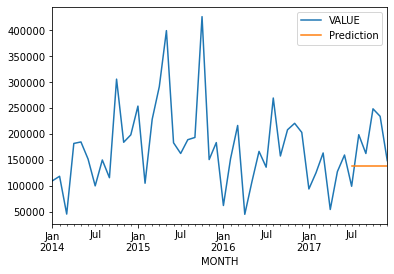

In [72]:
#Conactenating the observed and forecast model and plotting the graph
pd.concat([ABC_df_Pesticides_AA['VALUE'],forecast_df],axis=1).plot()

In [73]:
forecast1 = model.predict(n_periods=predict_periods,return_conf_int=True)
forecast1

(array([138439.94624998, 138439.94624998, 138439.94624998, 138439.94624998,
        138439.94624998, 138439.94624998]),
 array([[-36736.6512988 , 313616.54379876],
        [-42066.54931719, 318946.44181715],
        [-47243.51977517, 324123.41227513],
        [-52280.01643952, 329159.90893948],
        [-57186.88928507, 334066.78178503],
        [-61973.65956217, 338853.55206213]]))

In [74]:
forecast_range=pd.date_range(start= pd.to_datetime(test_start_date) ,periods= predict_periods,freq='MS')
forecast_range

DatetimeIndex(['2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [75]:
forecast1_df = pd.DataFrame(forecast1[0],index= forecast_range,columns=['Prediction'])

In [76]:
forecast1_df

Prediction
2017-07-01  138439.94625
2017-08-01  138439.94625
2017-09-01  138439.94625
2017-10-01  138439.94625
2017-11-01  138439.94625
2017-12-01  138439.94625

<AxesSubplot:>

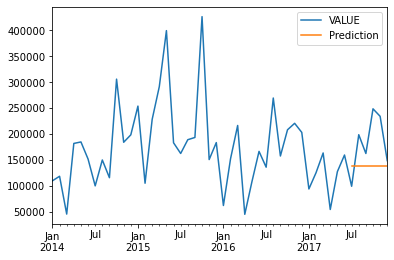

In [77]:
pd.concat([ABC_df_Pesticides_AA['VALUE'],forecast1_df],axis=1).plot()

In [78]:
lower = pd.Series(forecast1[1][:,0],index=forecast_range)
upper = pd.Series(forecast1[1][:,1],index=forecast_range)

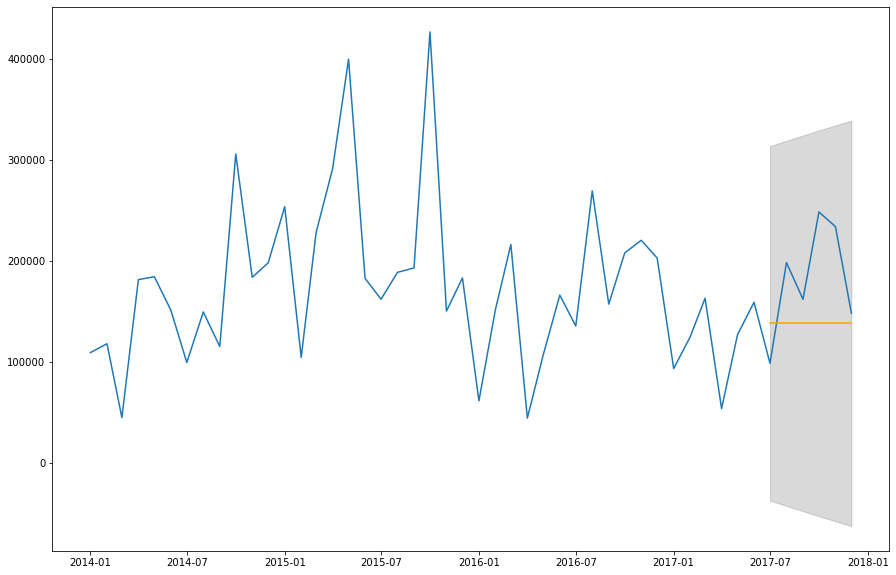

In [79]:
plt.figure(figsize=(15,10))
plt.plot(ABC_df_Pesticides_AA['VALUE'])
plt.plot(forecast1_df,color = 'orange')
plt.fill_between(forecast_range,lower,upper,color = 'k',alpha = .15)


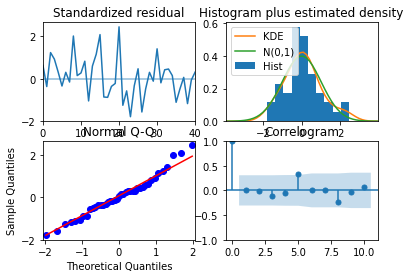

In [80]:
out = model.plot_diagnostics()

In [81]:
residuals_AA = test['VALUE'] - forecast_df['Prediction']
residuals_AA

MONTH
2017-07-01    -39494.80125
2017-08-01     60053.38875
2017-09-01     23777.94375
2017-10-01    110037.13875
2017-11-01     95561.08875
2017-12-01     10020.90375
dtype: float64

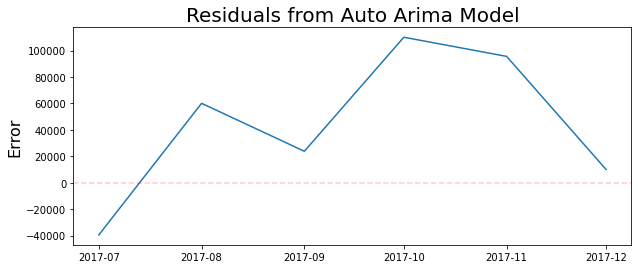

In [82]:
plt.figure(figsize=(10,4))
plt.plot(residuals_AA)
plt.title('Residuals from Auto Arima Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

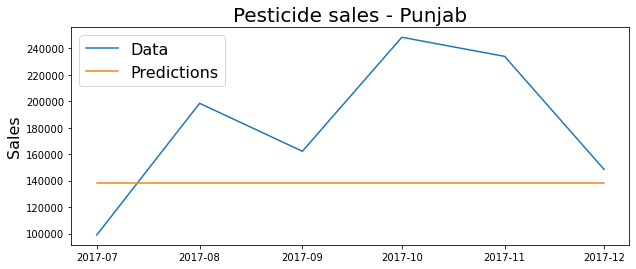

In [83]:
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(forecast_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pesticide sales - Punjab', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [84]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_AA**2)))

Root Mean Squared Error: 67171.61048943055


In [85]:
print(mean_absolute_error(test['VALUE'] ,forecast_df['Prediction']))

56490.877500012786


In [86]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = forecast_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

29.45014542500417

# ARMA model

In [87]:
ABC_df_Pesticides_ARMA = ABC_df_Pesticides.copy(deep=True)

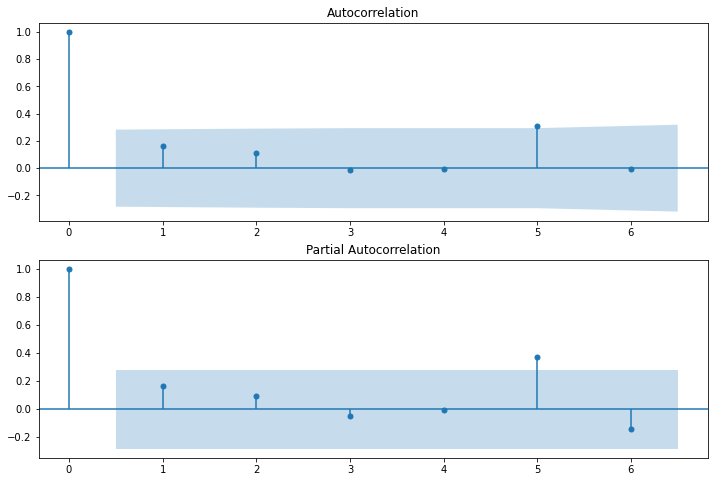

In [88]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ABC_df_Pesticides_ARMA,lags=predict_periods,ax = ax1)
ax2=fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(ABC_df_Pesticides_ARMA,lags=predict_periods,ax = ax2)

In [89]:
train = ABC_df_Pesticides_ARMA[(ABC_df_Pesticides_ARMA.index.get_level_values(0) >= pd.to_datetime(train_start_date)) &
                               (ABC_df_Pesticides_ARMA.index.get_level_values(0) <= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_ARMA[(ABC_df_Pesticides_ARMA.index.get_level_values(0) > pd.to_datetime(train_end_date))]

In [90]:
train

VALUE
MONTH                 
2014-01-01  109526.175
2014-02-01  118257.165
2014-03-01   45239.580
2014-04-01  181633.185
2014-05-01  184528.935
2014-06-01  151493.085
2014-07-01   99722.475
2014-08-01  149691.915
2014-09-01  115486.965
2014-10-01  305785.800
2014-11-01  183920.490
2014-12-01  198224.280
2015-01-01  253721.835
2015-02-01  104799.285
2015-03-01  228154.725
2015-04-01  291320.955
2015-05-01  399479.040
2015-06-01  182901.105
2015-07-01  162270.135
2015-08-01  188838.945
2015-09-01  193174.470
2015-10-01  426452.310
2015-11-01  150497.730
2015-12-01  183275.190
2016-01-01   61821.630
2016-02-01  152025.525
2016-03-01  216319.815
2016-04-01   44783.685
2016-05-01  107567.190
2016-06-01  166298.940
2016-07-01  135769.500
2016-08-01  269317.980
2016-09-01  157380.570
2016-10-01  208027.170
2016-11-01  220494.015
2016-12-01  202958.730
2017-01-01   93745.890
2017-02-01  125027.325
2017-03-01  163238.040
2017-04-01   54139.320
2017-05-01  127212.660
2017-06-01  159290.145

In [91]:
# define model
model = ARMA(train, order=(5,5))

In [92]:
model_fit = model.fit()

In [93]:
#summary of the model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  VALUE   No. Observations:                   42
Model:                     ARMA(5, 5)   Log Likelihood                -528.136
Method:                       css-mle   S.D. of innovations          63765.426
Date:                Wed, 23 Jun 2021   AIC                           1080.272
Time:                        13:20:01   BIC                           1101.124
Sample:                    01-01-2014   HQIC                          1087.915
                         - 06-01-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.732e+05   1.55e+04     11.142      0.000    1.43e+05    2.04e+05
ar.L1.VALUE     0.3327      0.207      1.606      0.108      -0.073       0.739
ar.L2.VALUE    -0.3169      0.205     -1.542    

In [94]:
test

VALUE
MONTH                 
2017-07-01   98945.145
2017-08-01  198493.335
2017-09-01  162217.890
2017-10-01  248477.085
2017-11-01  234001.035
2017-12-01  148460.850

In [95]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 2017-07-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VALUE   6 non-null      float64
dtypes: float64(1)
memory usage: 96.0 bytes


In [96]:
#get the predictions and residuals
predictions = model_fit.predict(start=pd.to_datetime(test_start_date), end = pd.to_datetime(test_end_date))

In [97]:
predictions

2017-07-01    157243.617952
2017-08-01    215255.693202
2017-09-01    183165.127136
2017-10-01    133670.585687
2017-11-01    172044.546105
2017-12-01    204287.826136
Freq: MS, dtype: float64

In [98]:
Pred_range=pd.date_range(start = pd.to_datetime(test_end_date),periods= predict_periods,freq='MS')
Pred_range

DatetimeIndex(['2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [99]:
Pred_df = predictions.to_frame()
Pred_df.info()
Pred_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 2017-07-01 to 2017-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6 non-null      float64
dtypes: float64(1)
memory usage: 96.0 bytes


0
2017-07-01  157243.617952
2017-08-01  215255.693202
2017-09-01  183165.127136
2017-10-01  133670.585687
2017-11-01  172044.546105
2017-12-01  204287.826136

In [100]:
Pred_df.columns = ['PRED_VALUE']

In [101]:
residuals_ARMA = test['VALUE'] - Pred_df['PRED_VALUE']
residuals_ARMA

MONTH
2017-07-01    -58298.472952
2017-08-01    -16762.358202
2017-09-01    -20947.237136
2017-10-01    114806.499313
2017-11-01     61956.488895
2017-12-01    -55826.976136
dtype: float64

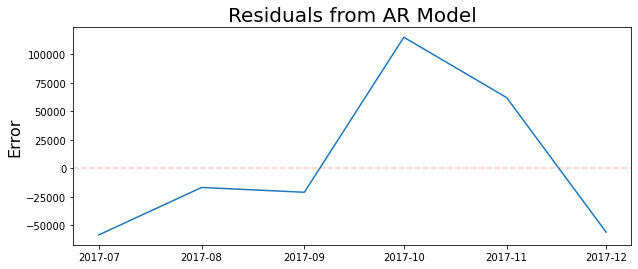

In [102]:
plt.figure(figsize=(10,4))
plt.plot(residuals_ARMA)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

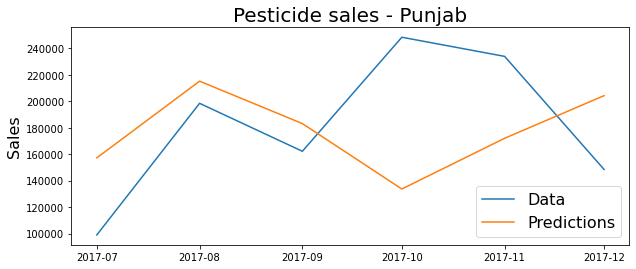

In [103]:
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(Pred_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pesticide sales - Punjab', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [104]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_ARMA**2)))

Root Mean Squared Error: 63579.694622742056


In [105]:
print(mean_absolute_error(test['VALUE'] ,Pred_df['PRED_VALUE']))

54766.338772494404


In [106]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = Pred_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

31.76045438756337

# SARIMAX Model

In [107]:
ABC_df_Pesticides_SARIMAX = ABC_df_Pesticides.copy(deep=True)

In [108]:
p = range(0, 3)
d = range(0, 1)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[0], x[0], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ABC_df_Pesticides_SARIMAX,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
               
            continue            

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (1, 1, 1, 12)
SARIMAX: (0, 0, 2) x (1, 1, 1, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1278.9681375360144
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1278.9681375360144
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1278.9681375360144
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:589.7781002844732
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:589.7781002844732
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:589.7781002844732
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1232.9837639472612
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1232.9837639472612
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1232.9837639472612
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:562.2431850000736
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:562.2431850000736
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:562.2431850000736
ARIMA(0, 0,

In [109]:
# Fitting the data to SARIMA model 
model = sm.tsa.statespace.SARIMAX(ABC_df_Pesticides_SARIMAX['VALUE'], 
                                order=(0, 0, 0),
                                seasonal_order=(2, 2, 2, 12),  
                                continueenforce_invertibility=False)

In [110]:
results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2925   3514.614  -8.32e-05      1.000   -6888.809    6888.224
ar.S.L24      -0.7838   8294.879  -9.45e-05      1.000   -1.63e+04    1.63e+04
ma.S.L12      -0.4852   3266.915     -0.000      1.000   -6403.522    6402.551
ma.S.L24       0.1791   2.94e+04   6.09e-06      1.000   -5.76e+04    5.76e+04
sigma2      3.709e+10      0.040   9.34e+11      0.000    3.71e+10    3.71e+10


In [111]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                         VALUE   No. Observations:                   48
Model:             SARIMAX(2, 2, [1, 2], 12)   Log Likelihood                -320.368
Date:                       Wed, 23 Jun 2021   AIC                            650.736
Time:                               13:21:49   BIC                            656.626
Sample:                           01-01-2014   HQIC                           652.299
                                - 12-01-2017                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2925   3514.614  -8.32e-05      1.000   -6888.809    6888.224
ar.S.L24      -0.7838   8294.879  -9.45e-05      1.000   -1.63e+04    1.63e+04
ma.S.L12      -0.4852   3266.915     -0.000      1.000   -6403.522    6402.551
ma.S.L24       0.1791   2.94e+04   6.09e-06      1.000   -5.76e+04    5.76e+04
sigma2      3.709e+10      0.040   9.34e+11      0.000    3.71e+10    3.71e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.53   Prob(JB):                         0.78
Heteroskedasticity (H):               0.42   Skew:                            -0.29
Prob(H) (two-sided):                  0.24   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.49e+27. Standard errors may be unstable.
"""

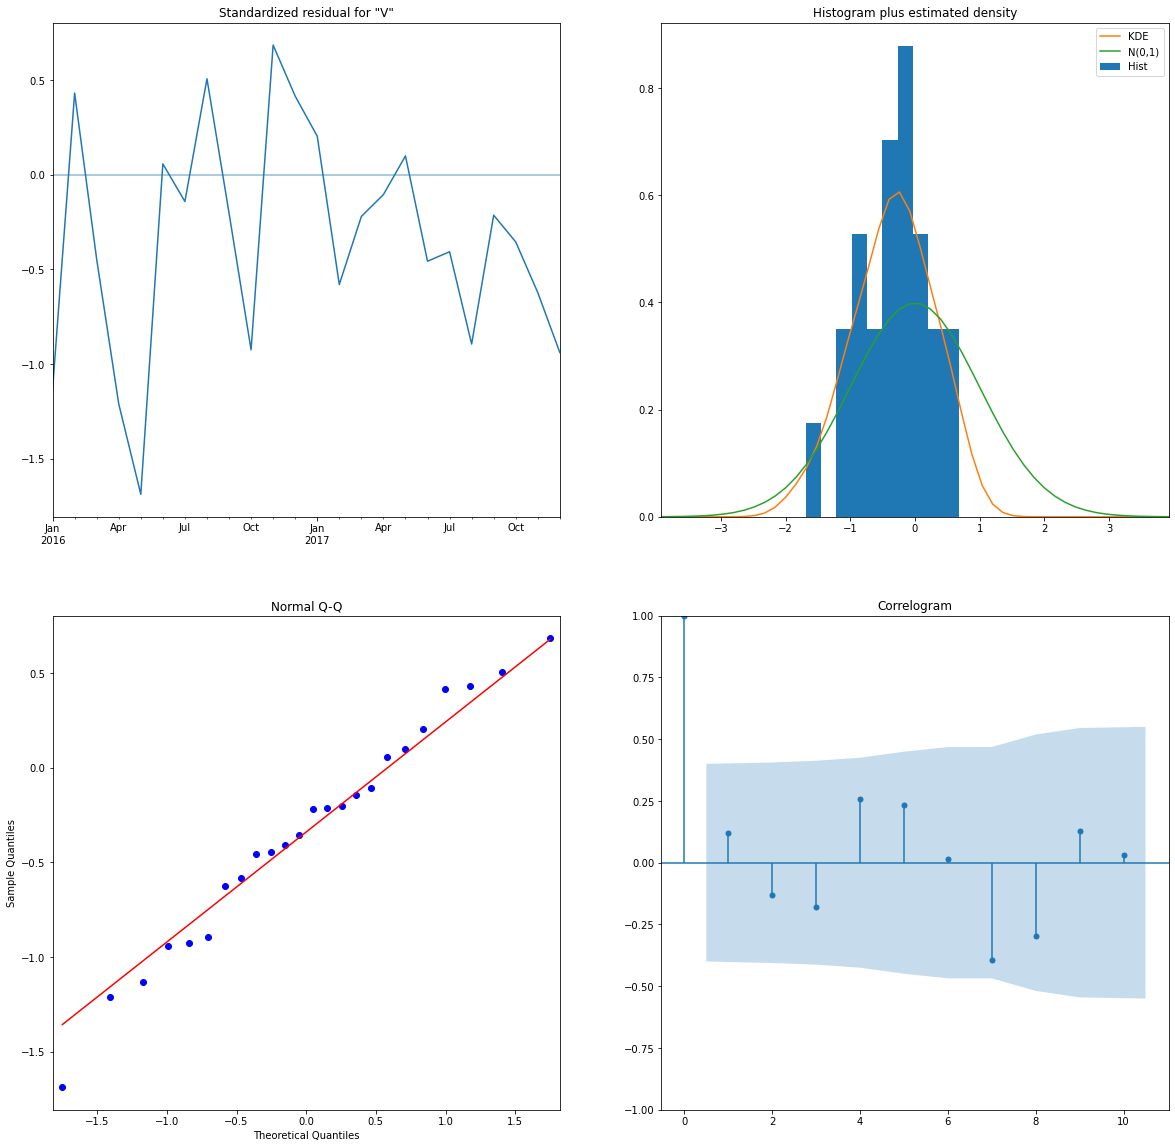

In [112]:
# Checking diagnostic plots
results.plot_diagnostics(figsize=(20, 20))
plt.show()

In [113]:
train = ABC_df_Pesticides_SARIMAX[(ABC_df_Pesticides_SARIMAX.index.get_level_values(0) >= pd.to_datetime(train_start_date)) &
                               (ABC_df_Pesticides_SARIMAX.index.get_level_values(0) <= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_SARIMAX[(ABC_df_Pesticides_SARIMAX.index.get_level_values(0) > pd.to_datetime(train_end_date))]

In [114]:
forecast = results.predict(n_periods=predict_periods,return_conf_int=True)
forecast

2014-01-01    0.000000e+00
2014-02-01    1.822828e-10
2014-03-01   -2.969262e-10
2014-04-01   -9.773148e-10
2014-05-01   -4.975455e-10
2014-06-01   -2.494939e-11
2014-07-01   -7.006438e-10
2014-08-01   -9.315033e-10
2014-09-01   -4.553967e-10
2014-10-01   -4.608086e-10
2014-11-01    1.320431e-10
2014-12-01   -1.433459e-10
2015-01-01    1.890182e+05
2015-02-01    2.040859e+05
2015-03-01    7.807360e+04
2015-04-01    3.134591e+05
2015-05-01    3.184565e+05
2015-06-01    2.614438e+05
2015-07-01    1.720991e+05
2015-08-01    2.583354e+05
2015-09-01    1.993052e+05
2015-10-01    5.277192e+05
2015-11-01    3.174064e+05
2015-12-01    3.420916e+05
2016-01-01    2.954299e+05
2016-02-01    6.329869e+04
2016-03-01    3.084887e+05
2016-04-01    2.942685e+05
2016-05-01    4.554294e+05
2016-06-01    1.546245e+05
2016-07-01    1.650781e+05
2016-08-01    1.650487e+05
2016-09-01    1.991132e+05
2016-10-01    3.986749e+05
2016-11-01    7.956272e+04
2016-12-01    1.176041e+05
2017-01-01    5.459055e+04
2

In [115]:
Predicted_df = pd.DataFrame(forecast.loc[forecast.index.isin(test.index)], columns=["PRED_VALUE"])
Predicted_df

Empty DataFrame
Columns: [PRED_VALUE]
Index: []

<AxesSubplot:>

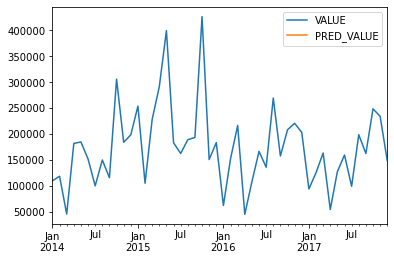

In [116]:
pd.concat([ABC_df_Pesticides_SARIMAX['VALUE'], Predicted_df], axis=1).plot()

In [117]:
residuals_SARIMAX = test['VALUE'] - Pred_df['PRED_VALUE']
residuals_SARIMAX

MONTH
2017-07-01    -58298.472952
2017-08-01    -16762.358202
2017-09-01    -20947.237136
2017-10-01    114806.499313
2017-11-01     61956.488895
2017-12-01    -55826.976136
dtype: float64

In [118]:
#get the predictions

predict_future = results.forecast(len(test))
predict_future

2018-01-01    268069.544707
2018-02-01    140487.496971
2018-03-01    281185.696563
2018-04-01    238735.235380
2018-05-01    389355.074634
2018-06-01    231837.008439
Freq: MS, Name: predicted_mean, dtype: float64

In [119]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_SARIMAX**2)))

Root Mean Squared Error: 63579.694622742056


In [120]:
print(mean_absolute_error(test['VALUE'] ,Pred_df['PRED_VALUE']))

54766.338772494404


In [121]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = Pred_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

31.76045438756337

# Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive errors

In [122]:
ABC_df_Pesticides_hwm =  ABC_df_Pesticides.copy(deep=True)

In [123]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [124]:
#Splitting the data into training and testing set
train = ABC_df_Pesticides_hwm[(ABC_df_Pesticides_hwm.index.get_level_values(0)>= pd.to_datetime(train_start_date) ) &
                               (ABC_df_Pesticides_hwm.index.get_level_values(0)<= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_hwm[(ABC_df_Pesticides_hwm.index.get_level_values(0)> pd.to_datetime(train_end_date))]

In [125]:
pred1 = ExponentialSmoothing(np.asarray(train['VALUE']), trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 12).fit() #[:'2017-01-01']
print('')
print('== Holt-Winters Additive ETS(A,A,A) Parameters ==')
print('')
alpha_value = np.round(pred1.params['smoothing_level'], 4)
print('Smoothing Level: ', alpha_value)
print('Smoothing Slope: ', np.round(pred1.params['smoothing_trend'], 4))
print('Smoothing Seasonal: ', np.round(pred1.params['smoothing_seasonal'], 4))
print('Initial Level: ', np.round(pred1.params['initial_level'], 4))
print('Initial Slope: ', np.round(pred1.params['initial_trend'], 4))
print('Initial Seasons: ', np.round(pred1.params['initial_seasons'], 4))
print('')

### Forecast for next 6 months

y_pred1 =  pred1.forecast(steps = 6)
df_pred1 = pd.DataFrame({'Y_hat':y_pred1,'Y':test['VALUE']})
print(df_pred1)


== Holt-Winters Additive ETS(A,A,A) Parameters ==

Smoothing Level:  0.2171
Smoothing Slope:  0.0668
Smoothing Seasonal:  0.1253
Initial Level:  129703.8825
Initial Slope:  6398.4422
Initial Seasons:  [-20177.7075 -11446.7175 -84464.3025  51929.3025  54825.0525  21789.2025
 -29981.4075  19988.0325 -14216.9175 176081.9175  54216.6075  68520.3975]

                    Y_hat           Y
MONTH                                
2017-07-01   84186.116015   98945.145
2017-08-01  139371.294604  198493.335
2017-09-01   95224.459892  162217.890
2017-10-01  270219.574457  248477.085
2017-11-01  149032.337962  234001.035
2017-12-01  161112.760440  148460.850


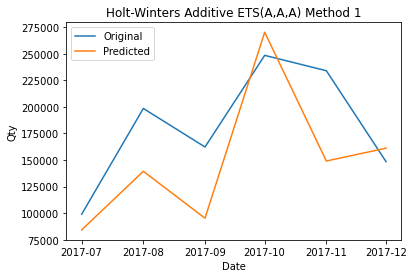

In [126]:
### Plot

fig2, ax = plt.subplots()
ax.plot(df_pred1.Y, label='Original')
ax.plot(df_pred1.Y_hat, label='Predicted')

plt.legend(loc='upper left')
plt.title('Holt-Winters Additive ETS(A,A,A) Method 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

In [127]:
residuals_hwm = df_pred1.Y - df_pred1.Y_hat
residuals_hwm


MONTH
2017-07-01    14759.028985
2017-08-01    59122.040396
2017-09-01    66993.430108
2017-10-01   -21742.489457
2017-11-01    84968.697038
2017-12-01   -12651.910440
dtype: float64

In [128]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_hwm**2)))

Root Mean Squared Error: 51726.60572141067


In [129]:
print(mean_absolute_error(df_pred1.Y, df_pred1.Y_hat))

43372.93273742038


In [130]:

mape    =  p_mean_absolute_percentage_error(df_pred1.Y, df_pred1.Y_hat)

print("For alpha = %1.2f,  MAPE is %3.2f" %(alpha_value, mape))

For alpha = 0.22,  MAPE is 23.26


In [144]:
#Future forecast
final_model = ExponentialSmoothing(ABC_df_Pesticides_hwm['VALUE'], trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 6).fit()

In [145]:
pred=final_model.forecast(6)
pred

2018-01-01    140088.930547
2018-02-01    184002.456654
2018-03-01    157341.051067
2018-04-01    214981.247049
2018-05-01    215006.159374
2018-06-01    201119.200395
Freq: MS, dtype: float64

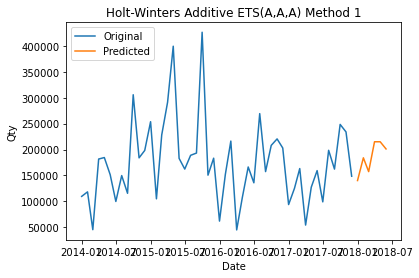

In [146]:
### Plot

fig2, ax = plt.subplots()
ax.plot(ABC_df_Pesticides_hwm['VALUE'], label='Original')
ax.plot(pred, label='Predicted')

plt.legend(loc='upper left')
plt.title('Holt-Winters Additive ETS(A,A,A) Method 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

# To check if Rainfall has any effect on Insecticides sales

In [147]:
Rainfall = [12.9,16.7,26.5,7.5, 20,25.8,71,33.5,67,10.8,0.2,9.4,12.1,6.6,70.7,34.9,8.3,43.5,127.9,84.4,32,3.8,2.3,0.2,
            0,1.1,20.7,0.6,26.8,34.8,155.1,133.8,13.7,5.2,0,0.9,33.8,0.3,7.2,3.7,10.1,121.8,67.7,74.7,91.8,0,1.8,4.2]

In [148]:
ABC_df_Pesticides['Rainfall'] = Rainfall[rolling_period - 1:]

Text(0, 0.5, 'Sales')

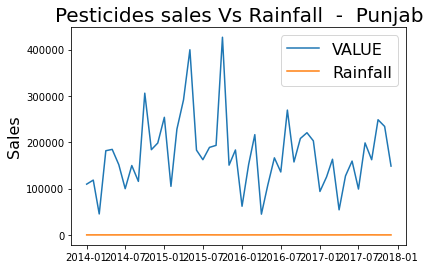

In [149]:
plt.plot(ABC_df_Pesticides)

plt.legend(('VALUE', 'Rainfall'), fontsize=16)

plt.title('Pesticides sales Vs Rainfall  -  Punjab', fontsize=20)
plt.ylabel('Sales', fontsize=16)

#Feature scaling for 'VALUE' column as Rainfall column

In [150]:
#Taking Rainfall and Value column on a common scale
ABC_df_Pesticides['VALUE'] = ABC_df_Pesticides['VALUE']/10000

In [151]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

array([<AxesSubplot:xlabel='MONTH'>, <AxesSubplot:xlabel='MONTH'>],
      dtype=object)

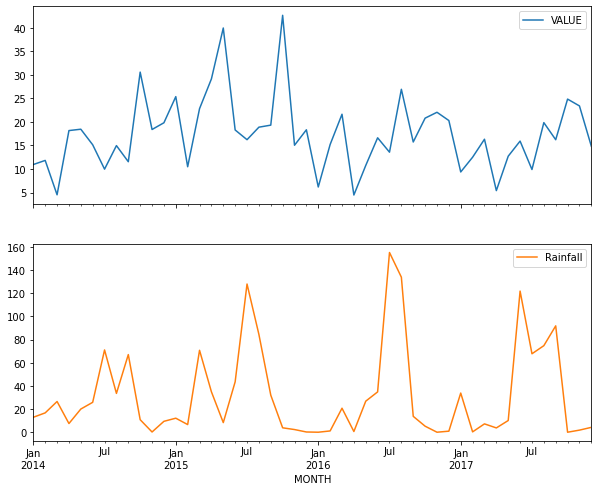

In [152]:
ABC_df_Pesticides.plot(subplots=True)

<AxesSubplot:xlabel='MONTH'>

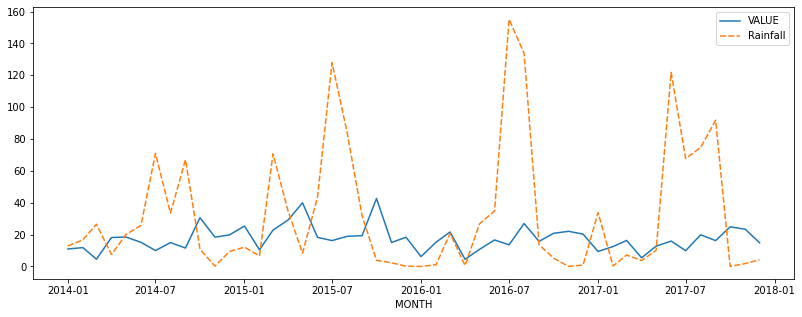

In [153]:
plt.figure(figsize = (30,5))
plt.subplot(1,2,1)
sns.lineplot(data=ABC_df_Pesticides)

In [154]:
#to find the coorelation betwween Rainfall and Value

In [155]:
col1 = ABC_df_Pesticides["Rainfall"]
col2 = ABC_df_Pesticides["VALUE"]

In [156]:
correlation = col1.corr(col2)
correlation

-0.04451515215731821

<AxesSubplot:>

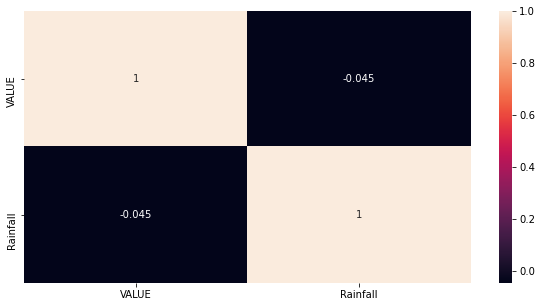

In [157]:
plt.figure(figsize = (10,5))
sns.heatmap(ABC_df_Pesticides.corr(),annot = True)